In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Load your data
df = pd.read_csv('data/bank.csv', sep=';')

#feature engineer high paying job
df['high_paying_job'] = 0

# Set to 1 where job is 'unemployed' or 'services'
df.loc[df['job'].isin(['entrepreneur','services','self-employed','blue-collar','admin.','management']), 'high_paying_job'] = 1


# One-hot encode the 'education' column
education_dummies = pd.get_dummies(df['education'], prefix='education')
# Ensure columns are 1/0 
education_dummies = education_dummies.astype(int)
# Concatenate the new columns to your original DataFrame
df = pd.concat([df, education_dummies], axis=1)


#feature engineer good bank relationship
df['good_bank_relationship'] = 0
df.loc[(df['housing'] == 'yes') | (df['default'] == 'no') & (df['loan'] == 'yes') , 'good_bank_relationship'] = 1


# Assign 1 if poutcome is 'success', else 0
df['poutcome'] = (df['poutcome'] == 'success').astype(int)


# Encode target variable: 1 for 'yes', 0 for 'no'
df['y'] = (df['y'] == 'yes').astype(int)

# Log-transform features (add 1 to avoid log(0); for pdays, campaign, previous)
for col in ['pdays', 'campaign', 'previous']:
    df[f'log_{col}'] = np.log1p(df[col].clip(lower=0))  # clip negatives to 0
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,...,y,high_paying_job,education_primary,education_secondary,education_tertiary,education_unknown,good_bank_relationship,log_pdays,log_campaign,log_previous
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,...,0,0,1,0,0,0,0,0.000000,0.693147,0.000000
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,...,0,1,0,1,0,0,1,5.828946,0.693147,1.609438
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,...,0,1,0,0,1,0,1,5.802118,0.693147,0.693147
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,...,0,1,0,0,1,0,1,0.000000,1.609438,0.000000
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,...,0,1,0,1,0,0,1,0.000000,0.693147,0.000000


              precision    recall  f1-score   support

           0       0.92      0.60      0.72       801
           1       0.17      0.62      0.26       104

    accuracy                           0.60       905
   macro avg       0.55      0.61      0.49       905
weighted avg       0.84      0.60      0.67       905

ROC AUC: 0.656


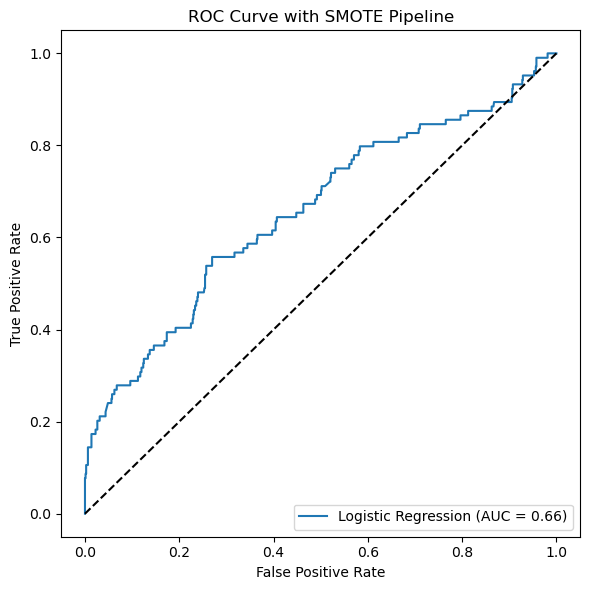

Elapsed time for Logistic Regression  : 1.5076 seconds


In [2]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import time

start_time = time.perf_counter()
# Features and target
X = df[['high_paying_job','good_bank_relationship' ,'balance','poutcome','education_tertiary','log_pdays']]
y = df['y']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define and fit pipeline directly
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced',
        C=1.0,          
        penalty='l2'    
    ))
])

# Fit pipeline directly 
pipeline.fit(X_train, y_train)

# Predictions and probabilities
y_pred = pipeline.predict(X_test)
y_score = pipeline.predict_proba(X_test)[:, 1]

# Print metrics
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_score):.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_score):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with SMOTE Pipeline')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
end_time = time.perf_counter()   

elapsed = end_time - start_time
print(f"Elapsed time for Logistic Regression  : {elapsed:.4f} seconds")

              precision    recall  f1-score   support

           0       0.91      0.67      0.77       801
           1       0.16      0.49      0.24       104

    accuracy                           0.65       905
   macro avg       0.54      0.58      0.51       905
weighted avg       0.82      0.65      0.71       905

ROC AUC: 0.594


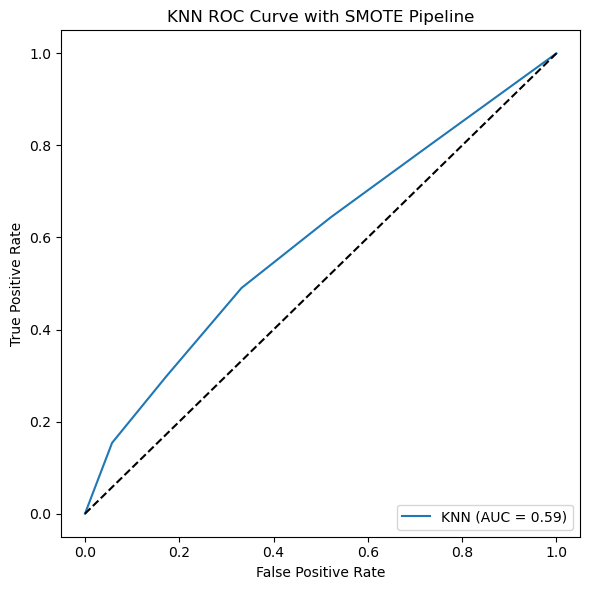

Elapsed time for KNN : 1.7027 seconds


In [3]:
from sklearn.neighbors import KNeighborsClassifier

start_time = time.perf_counter()

# Features and target
X = df[['high_paying_job','good_bank_relationship' ,'balance','poutcome','education_tertiary','log_pdays']]
y = df['y']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define and fit pipeline directly
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5))  # Default k=5
])

# Fit pipeline directly without hyperparameter search
pipeline.fit(X_train, y_train)

# Predictions and probabilities
y_pred = pipeline.predict(X_test)
y_score = pipeline.predict_proba(X_test)[:, 1]

# Print metrics
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_score):.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc_score(y_test, y_score):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve with SMOTE Pipeline')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
end_time = time.perf_counter()   

elapsed = end_time - start_time
print(f"Elapsed time for KNN : {elapsed:.4f} seconds")

              precision    recall  f1-score   support

           0       0.92      0.63      0.75       801
           1       0.17      0.61      0.27       104

    accuracy                           0.62       905
   macro avg       0.55      0.62      0.51       905
weighted avg       0.84      0.62      0.69       905

ROC AUC: 0.666


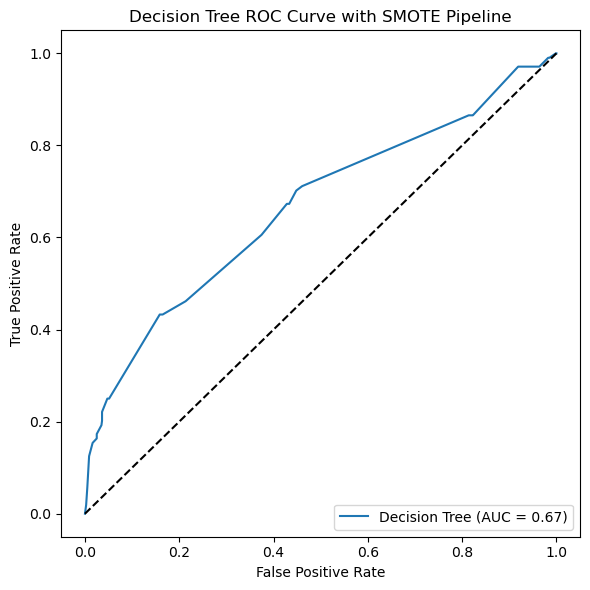

Elapsed time for Decision Tree : 1.0265 seconds


In [8]:
from sklearn.tree import DecisionTreeClassifier

start_time = time.perf_counter()
# # Features and target
X = df[['high_paying_job','good_bank_relationship' ,'balance','poutcome','education_tertiary','log_pdays']]
y = df['y']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define and fit pipeline directly
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('tree', DecisionTreeClassifier(
        max_depth=6,             # Example parameter, adjust as needed
        min_samples_split=10,    # Example parameter, adjust as needed
        criterion='gini',        # Example parameter, adjust as needed
        random_state=42
    ))
])

# Fit pipeline directly without hyperparameter search
pipeline.fit(X_train, y_train)

# Predictions and probabilities
y_pred = pipeline.predict(X_test)
y_score = pipeline.predict_proba(X_test)[:, 1]

# Print metrics
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_score):.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc_score(y_test, y_score):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve with SMOTE Pipeline')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
end_time = time.perf_counter()   

elapsed = end_time - start_time
print(f"Elapsed time for Decision Tree : {elapsed:.4f} seconds")

              precision    recall  f1-score   support

           0       0.92      0.75      0.82       801
           1       0.20      0.50      0.29       104

    accuracy                           0.72       905
   macro avg       0.56      0.62      0.56       905
weighted avg       0.84      0.72      0.76       905

ROC AUC: 0.665


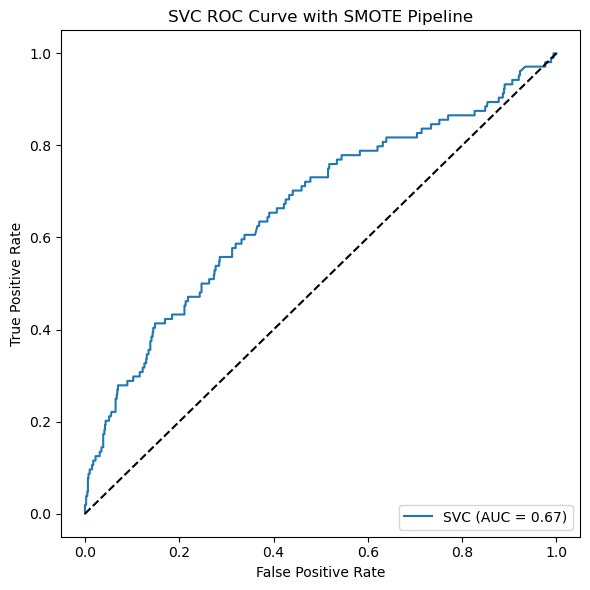

Elapsed time for SVC : 50.1022 seconds


In [7]:
from sklearn.svm import SVC

start_time = time.perf_counter()

# Features and target
X = df[['high_paying_job','good_bank_relationship' ,'balance','poutcome','education_tertiary','log_pdays']]
y = df['y']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define and fit pipeline directly
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svc', SVC(
        kernel='rbf',         
        C=1.0,                # Default regularization
        gamma='scale',        # Default gamma
        probability=True,     # Needed for predict_proba and ROC/AUC
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)

# Predictions and probabilities
y_pred = pipeline.predict(X_test)
y_score = pipeline.predict_proba(X_test)[:, 1]

# Print metrics
print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_score):.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'SVC (AUC = {roc_auc_score(y_test, y_score):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC ROC Curve with SMOTE Pipeline')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
end_time = time.perf_counter()   

elapsed = end_time - start_time
print(f"Elapsed time for SVC : {elapsed:.4f} seconds")
